<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Feature Selection on the Titanic Dataset

_Authors: Joseph Nelson (SF)_

---

In this lab you will explore a variety of different feature selection methods in sklearn. You will be using the titanic dataset.

You can load the titanic data as follows:

    psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
    password: gastudents

Or alternatively load the dataset from the local folder:

    ./datasets/titanic_train.csv
    

## Some useful feature selection resources

---

- Michigan State Overview on [feature selection](http://www.cse.msu.edu/~cse802/Feature_selection.pdf) and (bonus) Texas A&M on [bidrectional feature selection](http://research.cs.tamu.edu/prism/lectures/pr/pr_l11.pdf)
- Sklearn documentation on [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html)
- Side-by-side comparison of [feature selection tactics](http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/)

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Import the data and perform EDA. Engineer any features you think are predictive of survival.

We'll be working with the titanic datasets - go ahead and import it from the dataset folder (or query for it as described above). 

In [219]:
df = pd.read_csv('./datasets/titanic_train.csv')

In [220]:
# A:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [221]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [222]:
# Lets just drop obviously unuseful features
drop_df = df.drop(labels=['PassengerId','Ticket','Name'], axis=1)

In [223]:
# Maybe we can use the first letter to engineer this feature
drop_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

In [224]:
# Z cabin for all the nan values
cabin_dummy = pd.get_dummies(drop_df['Cabin'].map(lambda x: 'Z' if pd.isnull(x) else x.split()[0][0]), prefix='Cabin')
cabin_dummy = cabin_dummy.astype('int64')

In [225]:
# We will use Z as reference row
cabin_dummy.drop(labels='Cabin_Z', axis=1, inplace=True)

In [226]:
# combine with main df
drop_df = pd.concat([drop_df,cabin_dummy],axis=1)
drop_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  \
0         0       3    male  22.0      1      0   7.2500   NaN        S   
1         1       1  female  38.0      1      0  71.2833   C85        C   
2         1       3  female  26.0      0      0   7.9250   NaN        S   
3         1       1  female  35.0      1      0  53.1000  C123        S   
4         0       3    male  35.0      0      0   8.0500   NaN        S   

   Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  
0        0        0        0        0        0        0        0        0  
1        0        0        1        0        0        0        0        0  
2        0        0        0        0        0        0        0        0  
3        0        0        1        0        0        0        0        0  
4        0        0        0        0        0        0        0        0

In [227]:
# Now we will get room numbers
# Nan values default to 0
drop_df['Cabin_num'] = df['Cabin'].map(lambda x: 0 if pd.isnull(x) or x.split()[0][1:] == '' else int(x.split()[0][1:]))
drop_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  \
0         0       3    male  22.0      1      0   7.2500   NaN        S   
1         1       1  female  38.0      1      0  71.2833   C85        C   
2         1       3  female  26.0      0      0   7.9250   NaN        S   
3         1       1  female  35.0      1      0  53.1000  C123        S   
4         0       3    male  35.0      0      0   8.0500   NaN        S   

   Cabin_A  Cabin_B  Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  \
0        0        0        0        0        0        0        0        0   
1        0        0        1        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        1        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   Cabin_num  
0          0  
1         85  
2          0  
3        123  
4          0

In [228]:
# Only 2 nan values
drop_df[drop_df['Embarked'].isnull()].index

Int64Index([61, 829], dtype='int64')

In [229]:
# Create dummy variables for embark column
embark_dummy = pd.get_dummies(drop_df.Embarked,'Embark')
embark_dummy = embark_dummy.astype('int64')

In [230]:
# Combine with main frame
drop_df = pd.concat([drop_df, embark_dummy], axis=1)
drop_df.head()

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked  \
0         0       3    male  22.0      1      0   7.2500   NaN        S   
1         1       1  female  38.0      1      0  71.2833   C85        C   
2         1       3  female  26.0      0      0   7.9250   NaN        S   
3         1       1  female  35.0      1      0  53.1000  C123        S   
4         0       3    male  35.0      0      0   8.0500   NaN        S   

   Cabin_A    ...     Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  \
0        0    ...           0        0        0        0        0        0   
1        0    ...           1        0        0        0        0        0   
2        0    ...           0        0        0        0        0        0   
3        0    ...           1        0        0        0        0        0   
4        0    ...           0        0        0        0        0        0   

   Cabin_num  Embark_C  Embark_Q  Embark_S  
0          0         0         0         1  
1         85         1         0         0  
2          0         0         0         1  
3        123         0         0         1  
4          0         0         0         1  

[5 rows x 21 columns]

In [231]:
# Clean age column
# wants to replace with median age but lets check statistics first
print(drop_df.Age.mean())
print(drop_df.Age.median())

29.6991176471
28.0


In [232]:
# replace missing ages with median age since mean & median very close
# age most likely follows normal distribution
drop_df['Age'].fillna(drop_df.Age.median(), inplace=True)

In [233]:
# now lets drop unnecessary columns
drop_df = drop_df.drop(labels=['Cabin','Embarked'], axis=1)

In [234]:
# convert Sex column to binary
drop_df['Sex'] = drop_df['Sex'].map(lambda x: 1 if x == 'male' else 0)

In [235]:
drop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived     891 non-null int64
Pclass       891 non-null int64
Sex          891 non-null int64
Age          891 non-null float64
SibSp        891 non-null int64
Parch        891 non-null int64
Fare         891 non-null float64
Cabin_A      891 non-null int64
Cabin_B      891 non-null int64
Cabin_C      891 non-null int64
Cabin_D      891 non-null int64
Cabin_E      891 non-null int64
Cabin_F      891 non-null int64
Cabin_G      891 non-null int64
Cabin_T      891 non-null int64
Cabin_num    891 non-null int64
Embark_C     891 non-null int64
Embark_Q     891 non-null int64
Embark_S     891 non-null int64
dtypes: float64(2), int64(17)
memory usage: 132.3 KB


In [236]:
final_df = drop_df.drop(labels=['Embark_S'], axis=1)

In [237]:
final_df.rename(index=str, columns={"Sex": "Male"}, inplace=True)

### 2. Set up predictor and target matrices

- target should be `Survived`
- predictor matrix will be all other variables

In [238]:
# A:
Y = final_df['Survived']
X = final_df.drop(labels='Survived', axis=1)

### 3. Feature selection

Let's use the `SelectKBest` method in scikit learn to see which are the top 5 features. Also load the `f_classif` and `chi2` functions which will be our metrics to evaluate what makes a variable the "best".

```python
from sklearn.feature_selection import SelectKBest, f_classif, chi2
```

- What are the top 5 features for `X` using `f_classif`?
- What are the top 5 features for `X` using `chi2`?


> The f-test is explained variance divided by unexplained variance. High numbers will results if our explained variance, what we know is much greater than unexplained, what we dont know. The Chi2 goodness of fit is the sum of the difference squared between observed and expected divided by expected.

In [239]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# A:

# To find features that are different(f-value) but related(chi squared score) to our target, then the features are meaningful

# f_classif is ANOVA F-value for continuous variables against target
# testing for differences in variance
# if variance of variable and target are the same, then variable will be unable to predict target
# you cant use ticket fare to 
# h0 = variances equal, h1= variances different
# large value means variances are different which means variable is able reject null

# chi2 is Chi squared for categorical variables against target
# similar to pearson correlation but for categorical variables
# testing for differences in observed and expected frequencies,
# if variable and target are independent, observe count close to expected count, which means no difference
# h0 = no difference, h1= have difference
# large value means variable non randomly related to target, reject null

In [240]:
skb_chi2 = SelectKBest(chi2, 5)
skb_f = SelectKBest(f_classif, 5)

In [241]:
# fit the data
skb_chi2.fit(X,Y)
skb_f.fit(X,Y)

SelectKBest(k=5, score_func=<function f_classif at 0x1a136cf848>)

In [242]:
kbest = pd.DataFrame([X.columns, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['features','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest

features  f_classif chi2 score
1        Male    372.406    92.7024
0      Pclass    115.031    30.8737
5        Fare    63.0308    4518.32
14  Cabin_num    52.1563    3175.49
7     Cabin_B    28.1172    25.8756
15   Embark_C     25.896    20.4644
9     Cabin_D    20.6632    19.4896
10    Cabin_E    19.1792    18.1406
8     Cabin_C    11.8417    10.9367
4       Parch    5.96346    10.0975
2         Age    3.76153    21.6492
11    Cabin_F    2.99394    2.94697
3       SibSp    1.11057    2.58187
13    Cabin_T   0.622687   0.622951
6     Cabin_A   0.441793   0.435116
12    Cabin_G   0.228787   0.228214
16   Embark_Q  0.0118463  0.0108468

In [266]:
kbest_columns = kbest['features'].head(5).values
kbest_columns

array(['Male', 'Pclass', 'Fare', 'Cabin_num', 'Cabin_B'], dtype=object)

### 4. Recursive Feature Elimination (RFE)

Sklearn also offers recursive feature elimination as a class named `RFECV`. Use it in combination with a logistic regression model to see what features would be kept with this method.

When instantiating the `RFECV`:
- `step` indicates what percent of features (or number of features if an integer) to remove at each iteration.
- `cv` indicates the number of cross-validation folds to use for evaluating what features are important.

Store the columns in a variable called `rfecv_columns`.

In [243]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, Y)

print selector.support_
print selector.ranking_

[ True  True False  True  True False  True  True  True  True  True  True
  True  True False  True  True]
[1 1 2 1 1 4 1 1 1 1 1 1 1 1 3 1 1]


In [244]:
rfecv_columns = np.array(X.columns)[selector.support_]
rfecv_columns

array(['Pclass', 'Male', 'SibSp', 'Parch', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embark_C',
       'Embark_Q'], dtype=object)

### 5. Feature elimination using the lasso penalty

The L1 penalty is a popular method for feature selection. As the regularization strength increases more features will be removed.

Load the `LogisticRegressionCV` class.

1. Standardize your predictor matrix (required for regularization!)
- Create a logistic regression cross-validator object :
    - Set `penalty='l1'` (Lasso).
    - Set `Cs=100` (search 100 different regularization strengths).
    - Set `solver='liblinear'` (required for the Lasso penalty).
    - Set `cv=10` for 10 cross-validation folds.
- Fit on the target and standardized predictors.
- Sort the logistic regression coefficients by absolute value. Do the top 5 correspond to those selected by the f-score and chi2?



Choose which ones you would keep and store them in a variable called `lr_columns`

In [275]:
from sklearn.preprocessing import StandardScaler

# A:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

In [276]:
from sklearn.linear_model import LogisticRegressionCV

# A:
lr_cv = LogisticRegressionCV(penalty='l1',Cs=100,solver='liblinear',cv=10)
lr_cv.fit(Xs,Y)

LogisticRegressionCV(Cs=100, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [277]:
features = pd.DataFrame([X.columns, lr_cv.coef_[0],np.abs(lr_cv.coef_[0])], index=['features','coef','abs_coef'])
features = features.T.sort_values(by='abs_coef', ascending=False)
features.head(5)

features      coef  abs_coef
1      Male   -1.1406    1.1406
0    Pclass -0.665871  0.665871
2       Age -0.315447  0.315447
3     SibSp -0.197768  0.197768
10  Cabin_E  0.147665  0.147665

In [278]:
lr_columns = features['features'].head(5).values
lr_columns

array(['Male', 'Pclass', 'Age', 'SibSp', 'Cabin_E'], dtype=object)

### 6. Compare features sets

Use the optimized logistic regression from the previous question on the features selected from different methods. 
- `kbest_columns`
- `rfecv_columns`
- `lasso_columns`
- `all_columns`

**Questions:**
- Which scores the highest? (use cross_val_score)
- Is the difference significant?


In [279]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [280]:
# A:
print(kbest_columns)
print(rfecv_columns)
print(lr_columns)
print(X.columns)

['Male' 'Pclass' 'Fare' 'Cabin_num' 'Cabin_B']
['Pclass' 'Male' 'SibSp' 'Parch' 'Cabin_A' 'Cabin_B' 'Cabin_C' 'Cabin_D'
 'Cabin_E' 'Cabin_F' 'Cabin_G' 'Cabin_T' 'Embark_C' 'Embark_Q']
['Male' 'Pclass' 'Age' 'SibSp' 'Cabin_E']
Index([u'Pclass', u'Male', u'Age', u'SibSp', u'Parch', u'Fare', u'Cabin_A',
       u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_F', u'Cabin_G',
       u'Cabin_T', u'Cabin_num', u'Embark_C', u'Embark_Q'],
      dtype='object')


In [281]:
optimal_lr = LogisticRegression(C=lr_cv.C_[0], penalty='l1')

In [282]:
# defining a function to test our best features head-to-head
def score(X):
    scores = cross_val_score(optimal_lr, X, Y, cv=5)
    return scores.mean(), scores.std()

# list of all our lists of best features being executed in the score function
all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lr_columns]),
    score(Xs)]

#putting results into a dataframe
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])

mean score  std score
kbest    0.776691   0.019541
rfecv    0.787832   0.020027
lr       0.786715   0.018879
all      0.786753   0.014197

In [ ]:
# Almost no difference for features selected from different feature selection methods

### 7. [Bonus] Display the lasso logistic regression coefficients with a barchart.

Start from the most negative on the left.

In [292]:
# A:
features.set_index('features', inplace=True)

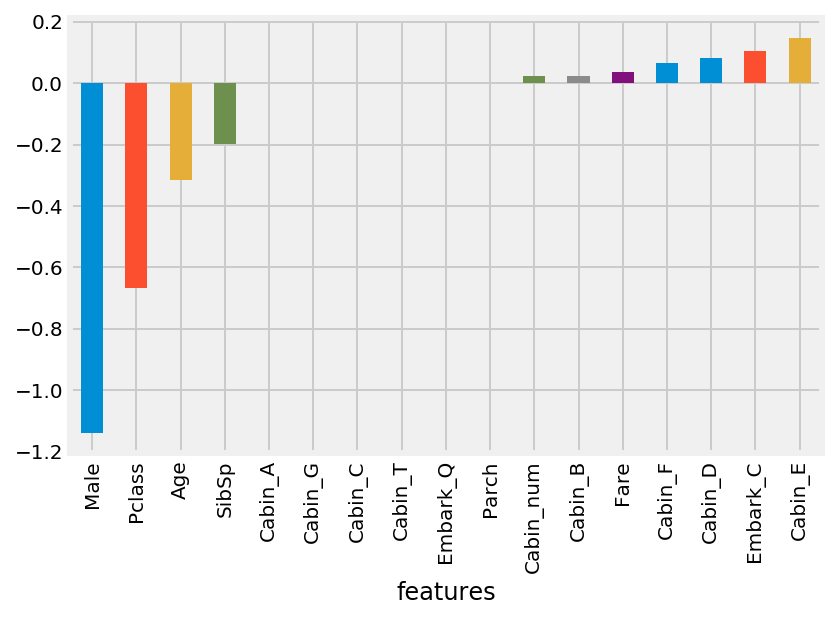

In [293]:
features['coef'].sort_values().plot(kind='bar')